**What I want to do: **First submission gave me a log loss of 0.27459 . This is of course ridiculous, but its ok because the model was trained on the sample data. Can I make it better. Fine tune the model? Also how can I check the validity of my predictions?

### Admin stuff

In [1]:
%matplotlib inline

#### Define paths for training, test and validation sets

In [2]:
data_dir = "data/data_kaggle_dogscats/"
train_path = "data/data_kaggle_dogscats/train/"
test_path = "data/data_kaggle_dogscats/test/"
validation_path = "data/data_kaggle_dogscats/valid/"
sample_train_path = "data/data_kaggle_dogscats/sample/train/"
sample_validation_path = "data/data_kaggle_dogscats/sample/valid/"
results_path = "data/data_kaggle_dogscats/results/"

In [22]:
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from datetime import datetime
import re
from keras.preprocessing import image

Jeremy has created a "utils.py" file with a whole host of convenience utility functions. I need to familiarise this in greater detail, especially the "plots" function. But lets simply use this for now.

In [29]:
import utils; reload(utils)
from utils import plots
from utils import save_array, load_array, plot_confusion_matrix, permutation

## Step 12: Load model weights with full training data 1 epoch

In [5]:
# import
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [6]:
# instantiate
vgg = Vgg16()

/home/ubuntu/anaconda2/lib/python2.7/site-packages/keras/layers/core.py:577: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [9]:
# load weights calculated and saved in the previous ipython notebook
vgg.model.load_weights(results_path+"fulltraining.h5")

In [10]:
# use this to run predictions on the test set
%time batches, predict_proba = vgg.test(test_path)

Found 12500 images belonging to 1 classes.
CPU times: user 6min 28s, sys: 1min 11s, total: 7min 40s
Wall time: 5min 17s


In [12]:
filenames = batches.filenames
save_array(results_path+"test_predictions_fulltraining1epoch.dat", predict_proba)
save_array(results_path+"filenames_fulltraining1epoch.dat", filenames)

Now save the predictions to a new submissions file:

In [13]:
# first load the saved test results
preds = load_array(results_path+"test_predictions_fulltraining1epoch.dat")
filenames = load_array(results_path+"filenames_fulltraining1epoch.dat")
isdog = preds[:,1]
isdog_clipped = np.clip(isdog, 0.05,0.95)
ids = [int(re.findall(r"\d+", i)[0]) for i in filenames]
submission = np.stack([ids,isdog_clipped],axis=1)

In [14]:
%cd $results_path
submission_file_name = 'submission3.csv'
np.savetxt(submission_file_name, submission, fmt='%d,%.5f', header='id,label', comments='')

/home/ubuntu/gitrepo/kaggle_dogs_cats/data/data_kaggle_dogscats/results


This has resulted in a log loss of 0.103, which puts me in the top 30% of the public scores. More tuning is required.

## Step 13: Understand the veracity of my predictions from sample using the validation set

Excellent points by Jeremy here. As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [7]:
vgg.model.load_weights(results_path+'sampletraining.h5')

In [8]:
%time val_batches, val_proba = vgg.test(validation_path, batch_size = 64)

Found 5000 images belonging to 2 classes.


In [9]:
filenames = val_batches.filenames
true_labels = val_batches.classes

In [50]:
val_batches.class_indices

{'cat': 0, 'dog': 1}

In [12]:
true_labels[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [51]:
val_proba[:,1][:5]

array([  9.1579e-09,   1.2091e-09,   2.4229e-09,   9.7005e-15,   1.4970e-06], dtype=float32)

In [53]:
predicted_labels = np.round(val_proba[:,1])
predicted_labels[:5]

array([ 0.,  0.,  0.,  0.,  0.], dtype=float32)

In [62]:
# check the validity of the predictions using confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels,predicted_labels,labels=['cat','dog'])

[[0 0]
 [0 0]]


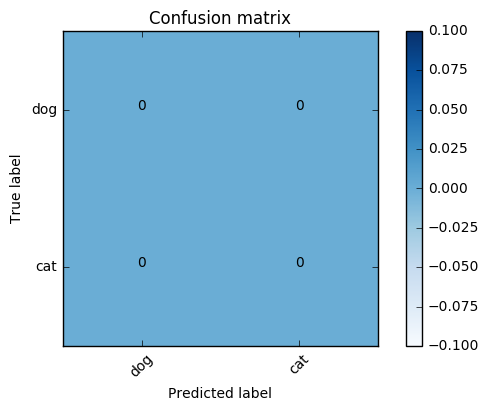

In [63]:
# import plot_confusion_matrix function from utils
plot_confusion_matrix(cm,val_batches.class_indices)

In [44]:
# check this by eye-balling the images. USE the PLOTS helper function in utils
def plots_idx(idx, titles=None):
    plots([image.load_img(validation_path+filenames[i]) for i in idx],titles=titles)

# define number of images to view in each frame
n_view = 4

Plot 4 arbitrary (true) dogs that were correctly predicted as dogs

In [57]:
true_dogs_pred_dogs = np.where((true_labels == predicted_labels) & (true_labels == 1))[0]
true_dogs_pred_dogs.shape

(2232,)

In [58]:
idx = permutation(true_dogs_pred_dogs)[:n_view]
idx

array([3857, 4472, 2534, 4236])

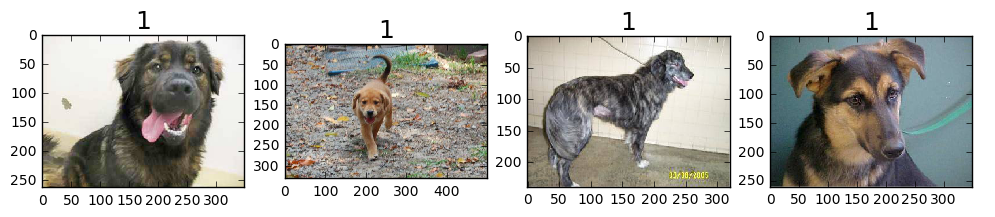

In [59]:
plots_idx(idx,true_labels[idx])